In [1]:
import mmf_setup;mmf_setup.nbinit()

<IPython.core.display.Javascript object>

# Minimization

Here we demonstrate some properties and problems with minimization techniques to find the ground state.

Recall that the GPE follows from minimizing the following energy $E$ at fixed total particle number $N$:

$$
  E[\psi] = \int \d^{d}{x} \left(
    \frac{\abs{-\I\hbar \vect\nabla \psi(x)}^2}{2m}
    + \frac{g}{2}n(x)^2
    + V(x)n(x)
  \right), \qquad
  N = \int \d^{d}{x} n(x), \qquad
  n(x) = \psi^\dagger(x)\psi(x)\\
  \op{H}\psi(x) = \pdiff{E[\psi]}{\psi^\dagger(x)}.
$$

Numerically, integrals are performed by summing over the lattice points, and include a factor of the metric $\d{x}^d$ which we call `metric` in the code and must be explicitly included in the minimizer.

Thus, we can formulate the problem as a minimization of the objective function

$$
  f(x) = E[\psi], \qquad N[x] = N_0, \qquad x = P(\psi)
$$

where $x = P(\psi)$ is a real parametrization of $\psi$ (i.e. the real and imaginary components in some order.  We use the underlying memory layout to efficiently do this conversion).  The minimizer requires the gradient, so se have:

$$
  \nabla f(x) = P\left(\mat{H}\psi\right)(2\d{x}^d).
$$

The last factor of `2*metric` accounts for the complex-to-real conversion and the metric implicit in the summation of the integral..

As we shall see below, we will also need to be able to minimize an auxilliary funtion:

$$
  g(x) = (\psi\mat{H})^\dagger (\mat{H}\psi).
$$

This requires a little care since $\mat{H}[n]$ itself depends non-linearly on the $\psi$ through the density $n$.  Let us consider a slightly more general non-linear energy density:

$$
  \frac{g}{2}{n(x)^2 = \mathcal{E}(n)
$$

The only portion of $\op{H}$ that depends on $n$ is $[H]_{ij} = \cdots + \mathcal{E}'(n_j)\delta_{ij}$, so the derivative is:

$$
  \pdiff{[H]_{ij}}{n_k} = g\delta_{ij}\delta_{jk}.
$$

The resulting derivative contains the piece 

$$
  \pdiff{g}{\psi^\dagger_k} = [\mat{H}^\dagger\mat{H}\psi]_k
    + \sum_{ij}\psi^\dagger_i\mathcal{E}''(n_j)\psi_j\delta_{jk}\delta_{ij}[\mat{H}\psi]_j
    + \sum_{ij}[\psi^\dagger\mat{H}^\dagger]_i\mathcal{E}''(n_j)\psi_j\delta_{jk}\delta_{ij}\psi_j    
  =  [\mat{H}^\dagger\mat{H}\psi]_k
    + \psi^\dagger_k\mathcal{E}''(n_k)\psi_k[\mat{H}\psi]_k
    + [\psi^\dagger\mat{H}^\dagger]_k\mathcal{E}''(n_k)\psi_k\psi_k
$$

$$
  \pdiff{g}{\psi^\dagger_k} = [\mat{H}^\dagger\mat{H}\psi]_k + n_k\mathcal{E}''(n_k)\psi_k
$$

## Harmonic Oscillator

As a simple test, we consider a simple harmonic oscillator setting $V(x) = m\omega^2x^2/2$ and $g=0$ which has a ground state wavefunction:

$$
  \psi_0(x) = \frac{1}{\pi^{1/4}\sqrt{a}} e^{-x^2/2a^2}, \qquad
  a = \sqrt{\frac{\hbar}{m\omega}}.
$$

To ensure we have a sufficiently large box, we choose $L$ so that the density falls by a factor of $10^{-15}$ at the boundary.  This will ensure that we have no long-range (IR) errors.

$$
  n(L/2) = e^{-L^2/4a^2} \approx 2^{-52} \approx 2\times 10^{-16} \approx e^{-36},\qquad
  L \approx 12.0 a.
$$

Populating the interactive namespace from numpy and matplotlib


bec.py:96: RuntimeWarning: invalid value encountered in true_divide
  n = np.maximum(0, (self.mu - V_ext))/self.g


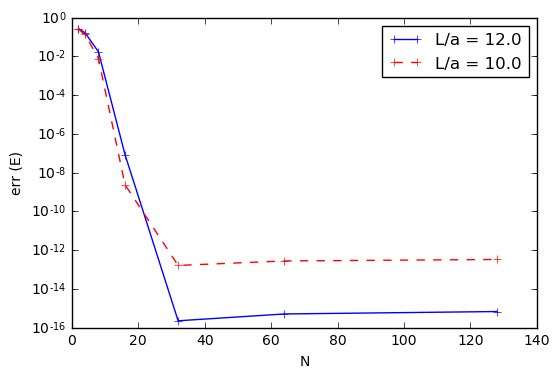

In [2]:
%pylab inline --no-import-all
import bec;reload(bec)
from bec import u
dim = 1
w = 1.0
a = np.sqrt(u.hbar/u.m/w)
N = 32
L = 12*a
E0 = dim * u.hbar * w / 2.0

def get_analytic_state(N=N, L=L):
    """Return the analytic ground state."""
    s = bec.State(Nxyz=(N,)*dim, Lxyz=(L,)*dim, ws=(w,)*dim, g=0.0, N=1.0)
    r2 = sum(_x**2 for _x in s.xyz)
    s[...] = np.sqrt(np.exp(-r2/a**2)/np.sqrt(np.pi)/a)
    return s

Ns = 2**np.arange(1,8)
Es = np.array([get_analytic_state(_N).get_energy() for _N in Ns])
Es_ = np.array([get_analytic_state(_N, L=L/1.1).get_energy() for _N in Ns])
plt.semilogy(Ns, abs(Es - E0), '-+', label='L/a = {}'.format(L/a))
plt.semilogy(Ns, abs(Es_ - E0), 'r--+', label='L/a = {}'.format(L/a/1.2))
plt.xlabel('N')
plt.ylabel('err (E)')
plt.legend(loc='best')

The errors here are due to an insufficient number of lattice points $N$ or too large of a lattice spacing $\d{x}$ (ultraviolet or UV errors).  Notice that the error decreases exponentially as a function of the lattice size, reaching machine precision at $N=32$:

$$
  \delta E \propto a^{-N} \propto (\d{x})^{N}.
$$

This exponential convergence is a special property of Fourier methods for analytic functions.  Finite-difference methods exhibit at best a power-law scaling $\delta E \propto N^{a}$ (though higher-order methods can have fairly large exponents).  The other curve shows a slightly smaller box, demonstrating that $L=12a$ is required for full convergence (infrared or IR errors).

### Exercise: Explain UV Errors

I explained above why $L=12a$ was required to reduce the errors to machine precision.  Explain why $N=32$ is sufficient for this purpose.

## Minimization

Having established that we can achieve machine precision in the energy, let's see how well the minimization routine can do.

In [3]:
import minimize;reload(minimize);from minimize import Minimize
s0 = get_analytic_state()

def get_sol(N=32, ftol=1e-12, gtol=1e-12):
    s = get_analytic_state(N=N)
    s[...] = np.sqrt(1./np.prod(s.Lxyz))   # Start with a constant density initial state
    s1 = Minimize(s).minimize(fix_N=True, ftol=ftol, gtol=gtol)[0]
    return s1

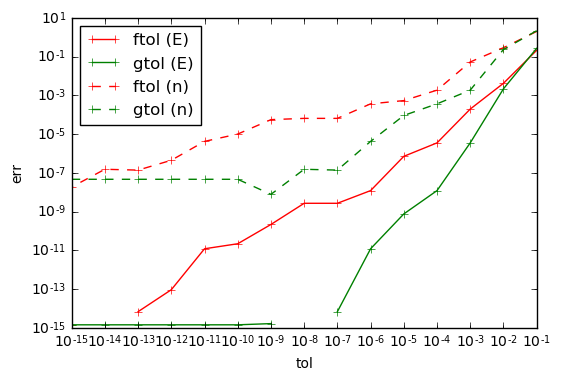

In [5]:
tols = 10.0**np.arange(-1, -16, -1)
dEs_f = []
dEs_g = []
dns_f = []
dns_g = []
for _t in tols:
    _sf = get_sol(ftol=_t, gtol=1e-32)
    _sg = get_sol(gtol=_t, ftol=1e-32)
    dEs_f.append(abs(_sf.get_energy() - E0))
    dEs_g.append(abs(_sg.get_energy() - E0))
    dns_f.append(abs(abs(_sf[...])**2 - abs(s0[...])**2).max())
    dns_g.append(abs(abs(_sg[...])**2 - abs(s0[...])**2).max())    

plt.loglog(tols, dEs_f, 'r+-', label='ftol (E)')
plt.loglog(tols, dEs_g, 'g+-', label='gtol (E)')
plt.loglog(tols, dns_f, 'r+--', label='ftol (n)')
plt.loglog(tols, dns_g, 'g+--', label='gtol (n)')

plt.xlabel('tol')
plt.ylabel('err')
plt.legend(loc='best')

Here we note several things.  First - the energy can be computed to machine precision, which requires `ftol`$\sim\epsilon$ and `gtol`$\sim \sqrt{\epsilon}$, however, the state itself can only be computed to an absolute accuracy of $\sqrt{\epsilon}$ because at this point, the energy no-longer changes.  This is a common problem with minimization proceedures.  About the minimium, the function is quadratic $f(x) \approx f_0 + a (x-x_0)^2$ so changes in $x \sim \delta$ will give rise to changes in $f(x_0+\delta) \approx f_0 + a\delta^2$.

To improve the situation, we can consider minimizing $\norm{\nabla{f}}$ instead of minimizing $f(x)$.  This is require that the state be stationary to machine precision.